# Stix Dispersion Solver

[stix]: ../../api_static/plasmapy.dispersion.analytical.stix_.rst
[bellan2012]: https://doi.org/10.1029/2012JA017856
[stix1992]: https://link.springer.com/book/9780883188590

This notebook details the functionality of the [stix()][stix] function. This is an analytical solution of equation 8 in [Bellan 2012][bellan2012], the function is defined by Stix [1992] in section 1-3 to be:

$$
        (S\sin^{2}(\theta) + P\cos^{2}(\theta))(ck/\omega)^{4}
            - [
                RL\sin^{2}(\theta) + PS(1 + \cos^{2}(\theta))
            ](ck/\omega)^{2} + PRL = 0
$$
where,

$$
        \mathbf{B_o} = B_{o} \mathbf{\hat{z}}   
         \cos \theta = \frac{k_z}{k} \\
        \mathbf{k} = k_{\rm x} \hat{x} + k_{\rm z} \hat{z}
$$

$$
        S = 1 - \sum_{s} \frac{\omega^{2}_{p,s}}{\omega^{2} -
            \omega^{2}_{c,s}}\hspace{2.5cm}
        P = 1 - \sum_{s} \frac{\omega^{2}_{p,s}}{\omega^{2}}\hspace{2.5cm}
        D = \sum_{s}
            \frac{\omega_{c,s}}{\omega}
            \frac{\omega^{2}_{p,s}}{\omega^{2} -
            \omega_{c,s}^{2}}
$$

$$
        R = S + D \hspace{1cm} L = S - D
$$

$\omega$ is the wave frequency, $k$ is the wavenumber, $\theta$ is the wave propagation angle with respect to the background magntic field $\mathbf{B_o}$, $s$ corresponds to plasma species $s$, $\omega_{p,s}$ is the plasma frequency of species $s$, and $\omega_{c,s}$ is the gyrofrequency of species $s$.

<div class="alert alert-info">
Note

The derivation of this dispersion relation assumed: 
* zero temperature for all plasma species ($T_{s}=0$)
* quasi-neutrallity
* a uniform background magntic field $\mathbf{B_o} = B_{o} \mathbf{\hat{z}}$
* no D.C. electric field $\mathbf{E_o}=0$
* zero-order quantities for all plasma parameters (densities, electric-field, magnetic field, particle speeds, etc.) are constant in time and space
* first-order perturbations in plasma parameters vary like $\sim e^{\left [ i (\textbf{k}\cdot\textbf{r} - \omega t)\right ]}$
    
</div>  

Due to the cold plasma assumption, this equation is valid for all $\omega$ and $k$ given $\frac{\omega}{k_{z}} \gg v_{Th}$ for all thermal speeds $v_{Th}$ of all plasma species and $k_{x} r_{L} \ll 1$ for all gyroradii $r_{L}$ of all plasma species. The relation predicts $k \to 0$ when any one of P, R or L vanish (cutoffs) and $k \to \infty$ for perpendicular propagation during wave resonance $S \to 0$.
 

## Contents

1. [Wave Normal to the Surface](#Wave-normal-to-the-surface)
2. [Comparision with Bellan](#Comparision-with-bellan)
3. 

In [1]:
from astropy import units as u
import matplotlib.pyplot as plt
import numpy as np

from astropy.constants.si import c
from astropy.constants import eps0

from plasmapy.dispersion.analytical.stix_ import stix
from plasmapy.dispersion.analytical.two_fluid_ import two_fluid
from plasmapy.formulary.frequencies import gyrofrequency, plasma_frequency
from plasmapy.formulary.lengths import inertial_length
from plasmapy.formulary import speeds
from plasmapy.particles import Particle


## Wave Normal to the Surface

Below we define the required parameters to compute the wave numbers.

In [2]:
# define input parameters
inputs_1 = {
    "theta": np.linspace(0, np.pi, 50) * u.rad,
    "ions": [Particle("p"),],
    "n_i": [2.0e12,] * u.cm**-3,
    "B": 0.43463 * np.sqrt(2) * u.T,
    "w": 500000 * 2 * np.pi * u.rad / u.s,
}

# define a meshgrid based on the number of theta values
omegas, thetas = np.meshgrid(
    inputs_1["w"].value, inputs_1["theta"].value, indexing="ij"
)
omegas = np.dstack((omegas,)*4).squeeze()
thetas = np.dstack((thetas,)*4).squeeze()

# compute k values
k = stix(**inputs_1)

[Quantity]: https://docs.astropy.org/en/stable/api/astropy.units.Quantity.html#astropy.units.Quantity

The computed wavenubmers in units (rad/m) are returned in a dictionary (shape $N \times M \times 4$), with the keys representing $\theta$ and the values (instances of Astropy [Quantity]) being the wavenumbers. The first dimension maps to the $w$ array, the second dimension maps to the $theta$ array, and the third dimension maps to the four roots of the Stix polynomial.
* $k[0]$ is the square root of the positive quadratic solution
* $k[1] = -k[0]$
* $k[2]$ is the square root of the negative quadratic solution
* $k[3] = -k[2]$

Below the values for $u_{x}$ and $u_{z}$ are calculated.

In [3]:
# calculate ux and uz
mask = np.imag(k) == 0
ux = omegas[mask] * np.sin(thetas[mask]) / (k.value[mask] * c.value)
uz = omegas[mask] * np.cos(thetas[mask]) / (k.value[mask] * c.value)


Let's plot the results.

/Users/elliotjohnson/opt/anaconda3/envs/test/lib/python3.9/site-packages/matplotlib/collections.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


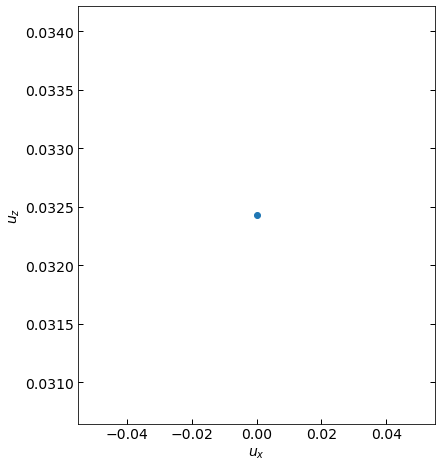

In [4]:
# plotting the results

fs = 14  # default font size
figwidth, figheight = plt.rcParams["figure.figsize"]
figheight = 1.6 * figheight
fig = plt.figure(figsize=[figwidth, figheight])

plt.scatter(ux[0], uz[0])

# adjust axes
plt.xlabel(r"$u_{x}$", fontsize=fs)
plt.ylabel(r"$u_{z}$", fontsize=fs)


plt.tick_params(
    which="both",
    direction="in",
    width=1,
    labelsize=fs,
    right=True,
    length=5,
)
plt.show()



Following on, the figures from Stix [1992] can be reproduced.

<Figure size 432x288 with 0 Axes>

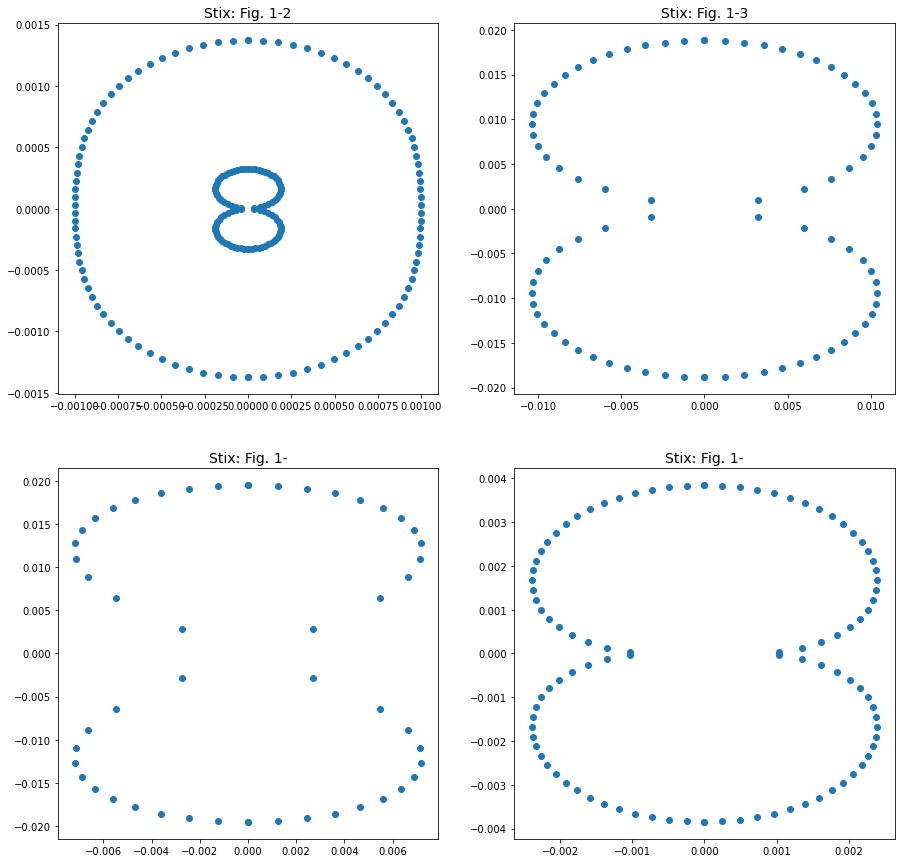

In [5]:
# define inputs
inputs_2 = {
    "theta": np.linspace(0, np.pi, 50) * u.rad,
    "ions": Particle("p"),
    "n_i": 1e15 * u.cm**-3,
    "B": 0.434 * u.T,
    "w": (37125810) * u.rad / u.s,
}

inputs_3 = {
    "theta": np.linspace(0, np.pi, 50) * u.rad,
    "ions": Particle("p"),
    "n_i": 1e15 * u.cm**-3,
    "B": 0.434534 * u.T,
    "w": (2 * 10**10) * u.rad / u.s,
}


inputs_4 = {
    "theta": np.linspace(0, np.pi, 50) * u.rad,
    "ions": Particle("p"),
    "n_i": 1e15 * u.cm**-3,
    "B": 0.434600 * u.T,
    "w": (54 * 10**9) * u.rad / u.s,
}


inputs_5 = {
    "theta": np.linspace(0, np.pi, 50) * u.rad,
    "ions": Particle("p"),
    "n_i": 1e15 * u.cm**-3,
    "B": 0.434634 * u.T,
    "w": (58 * 10**7) * u.rad / u.s,
}


inputs = [inputs_2, inputs_3, inputs_4, inputs_5]
ux = {}
uz = {}

for i, inpt in enumerate(inputs):
    omegas, thetas = np.meshgrid(
        inpt["w"].value, inpt["theta"].value, indexing="ij"
    )
    omegas = np.dstack((omegas,)*4).squeeze()
    thetas = np.dstack((thetas,)*4).squeeze()

    k = stix(**inpt)

    mask = np.imag(k) == 0
    ux[i] = omegas[mask] * np.sin(thetas[mask]) / (k.value[mask] * c.value)
    uz[i] = omegas[mask] * np.cos(thetas[mask]) / (k.value[mask] * c.value)


fs = 14  # default font size
figwidth, figheight = plt.rcParams["figure.figsize"]
figheight = 1.6 * figheight
fig = plt.figure()
fig, axs = plt.subplots(2, 2, figsize=[15, 15])


axs[0, 0].scatter(ux[0], uz[0])
axs[0, 0].set_title('Stix: Fig. 1-2', fontsize=fs)

axs[0, 1].scatter(ux[1], uz[1])
axs[0, 1].set_title('Stix: Fig. 1-3', fontsize=fs)

axs[1, 0].scatter(ux[2], uz[2])
axs[1, 0].set_title('Stix: Fig. 1-', fontsize=fs)

axs[1, 1].scatter(ux[3], uz[3])
axs[1, 1].set_title('Stix: Fig. 1-', fontsize=fs)

plt.show()


## Comparision with Bellan

Below we run a comparision between the solution provided in Bellan [2012] and our own solutions computed from [stix()][stix]. To begin we first have to define some parameter.

In the first instance a cold plasma limit of $T_{e} = \, {\rm K}$ and $T_{H+} = \, {\rm K}$ are assummed. In the second instance a warm plasma limit of $T_{e} = \, {\rm K}$ and $T_{H+} = \, {\rm K}$ are assummed.

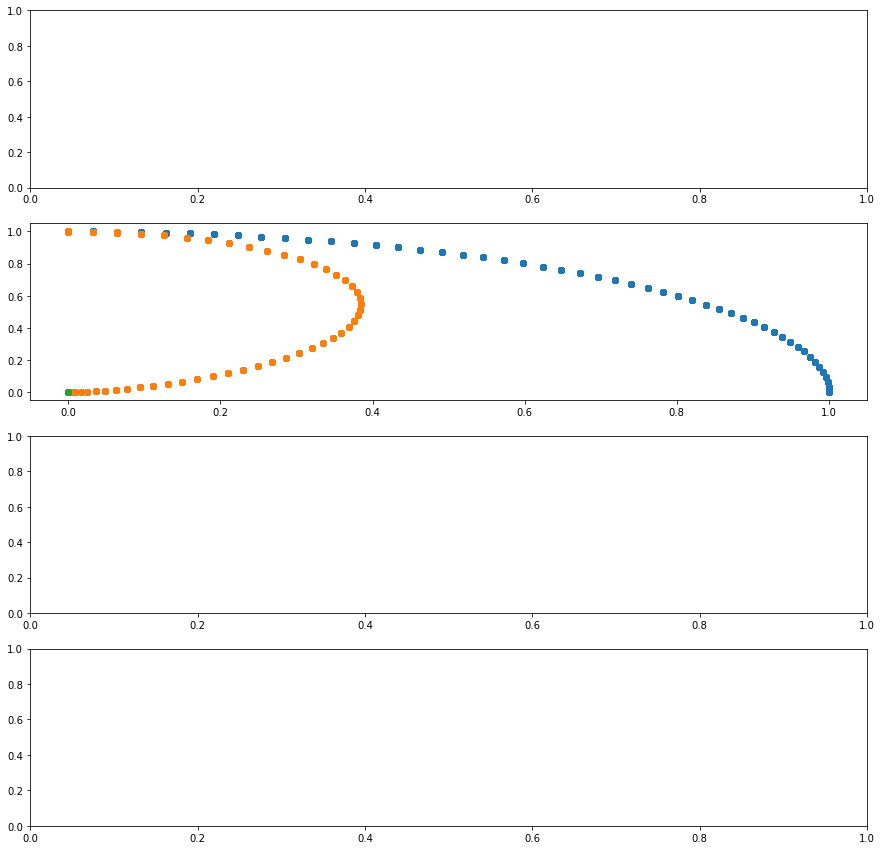

In [11]:

w_H = 500000 * 2 * np.pi 

inputs_H = {
    "theta": np.linspace(0, np.pi/2, 50) * u.rad,
    "ion": Particle("p"),
    "n_i": 2.0e12 * u.cm**-3,
    "B": 0.434634 * u.T,
    "k": (w_H/c.value) * u.rad / u.m,
    "T_e": 1000 * u.K,
    "T_i": 4.0e5 * u.K,
}

inputs_C = {
    "theta": np.linspace(0, np.pi/2, 50) * u.rad,
    "ion": Particle("p"),
    "n_i": 2.0e12 * u.cm**-3,
    "B": 0.434634 * u.T,
    "k": np.linspace(10**-7, 10**-2, 10000) * u.rad / u.m,
    "T_e": 1000 * u.K,
    "T_i": 4.0e5 * u.K,
}


inpts = [inputs_H, inputs_C]


for i, inpt in enumerate(inpts):
    k, thetas = np.meshgrid(inpt["k"].value, inpt["theta"].value, indexing="ij")
    
    omegas = two_fluid(**inpt)
    
    va = speeds.va_(inpt["B"], inpt["n_i"], ion=inpt["ion"])

    two_fluid_plt = {}
    
    for mode, arr in omegas.items():
        norm = (np.absolute(arr) / (k * va)).value ** 2
        two_fluid_plt[mode] = {
            "x": norm * np.sin(inpt["theta"].to(u.rad).value),
            "y": norm * np.cos(inpt["theta"].to(u.rad).value),
        }



fig, axs = plt.subplots(4, 1, figsize=(15, 15))


for mode, vals in two_fluid_plt.items():
    axs[i].scatter(vals['x'], vals['y'])
    #axs[i].scatter(ux[i], uz[i])


plt.show()  

#bellan style


In [ ]:
gamma = plasma_frequency(n = inputs_5["n_i"], particle=inputs_5["ions"])/gyrofrequency(B=inputs_5["B"], particle=inputs_5["ions"], signed=True)
beta = gyrofrequency(B=inputs_5["B"], particle=inputs_5["ions"], signed=True)/inputs_5["w"]
mu = plasma_frequency(n = inputs_5["n_i"], particle=Particle("e"))**2/plasma_frequency(n = inputs_5["n_i"], particle=inputs_5["ions"])**2
print('gamma: ',gamma, ' beta: ', beta, ' mu: ', mu)

gamma_k = 1000
beta_k = 0.000769
mu_k = 1836

w_s = gyrofrequency(B=inputs_2["B"], particle=inputs_2["ions"], signed=True)/beta_k

alpha = plasma_frequency(n = inputs_2["n_i"], particle=Particle("e"))**2/w_s**2

b_2_s = 0.137*np.sqrt(inputs_2["n_i"]*mu_k/(gamma_k))


print('w: ', w_s,' b:', (b_2_s))

two fluid
cold and warm plasma limits
change previous plots to line plots